In [1]:
from npy_append_array import NpyAppendArray
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


multiple_peaks_found=[]
no_start_found=[]


In [58]:
"""ToDo das als Import"""
def tag_peaks(input_data, prominence, distance, width):
    peaks = {}
    peaks_prop = {}
    for key in input_data.dtype.names:
        peaks[key], peaks_prop[key] = signal.find_peaks(
            input_data[key], prominence=prominence[key], distance=distance[key], width=width[key]
        )
    return peaks, peaks_prop

def import_data(filename, number_of_samples, channel_names):
    """
    Convert recorded pulses into a structured array, similar to how it would be handled by mimoCorb.

    Parameters:
    filename (str): Path to the file containing the recorded pulse data.
    number_of_samples (int): Number of samples to consider for each channel.
    channel_names (list): List of channel names.

    Returns:
    np.ndarray: Structured array containing the recorded pulse data.
    """
    # Load the data from the file using memory mapping to handle large files efficiently
    data = np.load(filename, mmap_mode='r')
    
    # Define the data type for each channel with the given number of samples
    dtype_sample = f'{number_of_samples}int16'
    dtype = np.dtype([(channel, dtype_sample) for channel in channel_names])
    
    # Initialize the structured array with the correct dtype
    structured_data = np.zeros(len(data), dtype=dtype)
    
    # Populate the structured array with data
    for i, record in enumerate(data):
        for j, channel in enumerate(channel_names):
            structured_data[i][channel] = record[j][:number_of_samples]
    
    # Print the number of recorded triggers
    print("Data read successfully, recorded triggers =", structured_data.size)
    
    return structured_data, structured_data.size


def peak_height(input_data,peak_postion,peak_prop,gradient_upper_bound,gradient_lower_bound,key):
    global no_start_found
    global i
    global color_table
    """This module takes a 1d array, and the peak position and properties (from scipy.signal.find_peaks) and returns the indizes of the starting position of each peak

        the start of the peak is here defined as the first time the gradient of the input_data is 0 before the left_ips of the peak
        
        ToDo: add the option to set a limit for the gradient
        
        returns None if no start could be found
    """
    gradient=np.gradient(input_data)
    right_bound=int(peak_prop['left_ips'])
    d,g=input_data[:right_bound],gradient[:right_bound]
    non_zeros=np.nonzero(np.logical_and(g<=gradient_upper_bound,g>=gradient_lower_bound))
    try:
        start=non_zeros[0][-1]
        #plt.hlines([input_data[start],input_data[peak_postion]],xmin=start,xmax=peak_postion,colors=color_table[key])
        #plt.vlines([start,peak_postion],ymin=input_data[start],ymax=input_data[peak_postion],colors=color_table[key])
    except:
        no_start_found.append(i)
        return None
    
    height=input_data[peak_postion]-input_data[start] 
    if filter(height,key):
        return None 

            
    #if height<1500:
    #    return None
    # if key=='ch2' and 2900<height<3100:
    #     return None
    return height
        

In [59]:
messung="5"

#later to be imported from config_dict
sample_time_ns = 256
analogue_offset = 0*1000
trigger_channel = 'ch2'
coincid_channel = 'ch1'

peak_minimal_prominence = {'ch1': 200, 'ch2': 200}
peak_minimal_distance = {'ch1': 400, 'ch2': 400}
peak_minimal_width = {'ch1': 10, 'ch2': 10}

gradient_lower_bound = {'ch1': 0, 'ch2': 0}
gradient_upper_bound = {'ch1': 0, 'ch2': 0}

number_of_samples=1000

window_us=8
window=window_us*1000/sample_time_ns

color_table={'ch1': "tab:orange", 'ch2': "tab:blue"}
channel_names=np.array(['ch1','ch2'])

In [60]:
data,number_of_triggers=import_data("measurements/measurement_3_" + messung +"min.npy",number_of_samples, channel_names)


Data read successfully, recorded triggers = 10810


In [61]:
def func(input_data):
    global multiple_peaks_found
    global i
    #print(input_data['ch1'])
    height={'ch1': 0,'ch2':0}
    peaks,peaks_prop=tag_peaks(input_data,peak_minimal_prominence,peak_minimal_distance,peak_minimal_width)
    #Check if multiple peaks were found, discard to be dealt with later
    n_peaks_1=len(peaks['ch1'])
    n_peaks_2=len(peaks['ch2'])
    if n_peaks_1>1 or n_peaks_2>1:
        #print("Mehrere Peaks gefunden, ToDo")
        #plt.plot(input_data['ch1'])
        #plt.plot(input_data['ch2'])
        #plt.show()
        multiple_peaks_found.append(i)
        return None
    if n_peaks_1==0 or n_peaks_2==0:
        return None
    
    #Check for coincidence
    if np.abs(peaks['ch1'][0]-peaks['ch2'][0])>window:
        return None
    else:
        for key in channel_names:
            property_list=list(peaks_prop[key].keys())
            for property in property_list:
                peaks_prop[key][property]=peaks_prop[key][property][0]
        for key in channel_names:
            ret_height=peak_height(input_data[key],peaks[key][0],peaks_prop[key],gradient_upper_bound[key],gradient_lower_bound[key],key)
            if ret_height!=None:
                height[key]=ret_height
            else:
                return None
    
    
    return height

In [94]:
def filter(height,key):
    """return True if event should be ignored"""
    # if height<1500:
    #     return True
    # if key=='ch2' and 2900<height<3100:
    #     return True
    
    # ### Cut of below Peak
    # if key=='ch1' and height<1200:
    #     return True
    # if key=='ch2' and height<2900:
    #     return True
    return False
    

In [95]:
heights1=[]
heights2=[]
#print(number_of_triggers)
for i in range(number_of_triggers):
    d=data[i]
    ret=func(d)
    if ret==None:
        continue
    #plt.plot(d['ch1'],color=color_table['ch1'])
    #plt.plot(d['ch2'],color=color_table['ch2'])
    #plt.show()
    heights1.append(ret['ch1'])
    heights2.append(ret['ch2'])





In [96]:
# for j in multiple_peaks_found:
#     plt.plot(data[j]['ch1'])
#     plt.plot(data[j]['ch2'])
#     plt.show()

In [97]:
# for j in no_start_found:
#     plt.plot(data[j]['ch1'])
#     plt.plot(data[j]['ch2'])
#     plt.show()

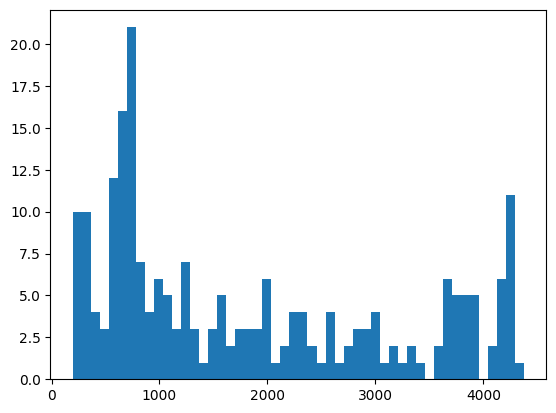

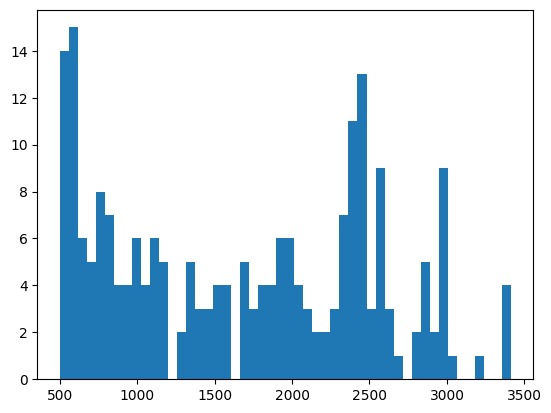

In [98]:
nbins=50
plt.hist(heights1,bins=nbins)
plt.show()
plt.hist(heights2,bins=nbins)
plt.show()